# Depth Degeneracy in Neural Networks
This notebook contains the code used to produce Figure 1 of *Depth Degeneracy in Neural Networks: Vanishing Angles in Fully Connected ReLU Networks on Initialization* by Jakub and Nica (2023).

Author: Cameron Jakub

In [1]:
#Import packages
import numpy as np
import time
import math
import scipy
import matplotlib.pyplot as plt

from jax import random
from jax import nn
from scipy import stats
from tqdm.notebook import tqdm_notebook

Here, we define necessary functions which we will use to simulate initialized neural networks. The `norm2` function is used to calculate the $\ell_2$ norm of the hidden layers. We use the `einsum` function to quickly calculate this norm for many neural networks ran at once. The input into the `norm2` function is an array of shape  `N_width` $\times$ `N_samples`, where `N_width` is the number of neurons in the hidden layers of the network, and `N_samples` is the number of neural network simulations we are running simultaneously. This function returns a `1` $\times$ `N_samples` array, which we will call $N$.

For an input $z$, entry $k$ of the array $N$ is given by

$$N_k = \sum_{i=1}^{\texttt{N_width}} z_{i,k}^2, $$

where $z_{i,k}$ represents node $i$ of the current hidden layer, for sample number $k$.

In [2]:
def norm2(z):
  return np.einsum("is,is->s",z,z)

def norm(z):
 return np.sqrt(norm2(z))

def unit_vector(z):
  return z/np.linalg.norm(z)

def angle_calc(v,w):
  return np.einsum('is,is -> s',v,w) / (norm(v)*norm(w))

# Initialize inputs $x_\alpha$, $x_\beta$

We want to create 2 inputs into our neural networks that have a desired angle $\theta^0$ between them. To do this, we let

$$x_\alpha  = (1,0,0,0,...,0) $$

$$ x_\beta = (\cos \theta^0 , \sin \theta^0 ,0,0,0,...,0 ). $$

To convince ourselves this works, note that the angle $\theta$ between $x_\alpha$ and $x_\beta$ satisfies the following equation:

$$\cos (\theta) = \frac{ \langle x_\alpha, x_\beta \rangle}{\|x_\alpha\| \|x_\beta\|}.$$

Solving for the right hand side of that equation, we get

$$\frac{1 \cdot \cos (\theta^0) + 0 \cdot \sin(\theta^0) + 0\;+\; ... \;+\; 0}{(1^2)(\cos^2(\theta^0) + \sin^2(\theta^0))} = \cos(\theta^0). $$

We see that the angle between $x_\alpha$ and $x_\beta$ is given by $\theta^0$, as desired.


In [3]:
N_width = 2**8 #network width
N_depth = 2**5 #network depth
N_samples = 5000

# Set the initial angle inputs
theta_init = 0.1

# x_alpha = (1,0,0,0,...,0)
x_alpha = np.zeros((N_width,1))
x_alpha[0] = 1

# x_beta = (cos(theta), sin(theta),0,0,0,...,0)
x_beta = np.zeros((N_width,1))
x_beta[0] = np.cos(theta_init)
x_beta[1] = np.sin(theta_init)

# Repeat vectors N_samples times, so we can run many networks simultaneously
z_alpha = np.tile(x_alpha, N_samples)
z_beta = np.tile(x_beta, N_samples)

# Run the Neural Network
Here, we take the 2 inputs we created, and feed them through the layers of each network on initialization. Networks are initialized using scaled Gaussian weights. To get from layer $\ell$ to layer $\ell+1$, we apply the ReLU activation function ($\varphi(x)$), multiply by a randomized weight matrix $W^{\ell+1}$, and apply the "He" normalization constant $\sqrt{2/n_\ell}$ (He et al., 2015). We will denote each layer as $z_\ell$.

$$z_{\ell+1} = \sqrt{\frac{2}{n_\ell}} W^{\ell+1} \varphi(z_\ell). $$

In [4]:
# Set random keys
key = random.PRNGKey(int(time.time()))
keys = random.split(key, N_depth)

# Initialize variables
cos_theta = np.zeros((N_depth, N_samples))
sin_theta = np.zeros((N_depth, N_samples))

# Propagate the inputs through the neural net
for layer in tqdm_notebook(range(N_depth)):
  # Set random keys
  key1, key2 = random.split(keys[layer], 2)

  # Apply ReLU function
  phi_alpha = nn.relu(z_alpha)
  phi_beta = nn.relu(z_beta)

  # Calculate initial norms
  normsq_alpha_init = norm2(phi_alpha)
  normsq_beta_init = norm2(phi_beta)

  # Calculate correlation between phi_alpha, phi_beta
  cos_theta[layer] = angle_calc(phi_alpha, phi_beta)
  cos_theta[layer] = np.clip(cos_theta[layer], -1, 1)
  sin_theta[layer] = np.sqrt(1-cos_theta[layer]**2)

  # Create random matrix of weights (normalized)
  W = random.normal(keys[layer],(N_width,N_width,N_samples))*math.sqrt(2/N_width)

  # The below performs matrix-vector multiplication between weight matrix W and layer phi N_samples_run times,
  # and stores the output in a N_width x N_samples_run matrix z
  z_alpha = np.einsum("ijs,js->is",W,phi_alpha)
  z_beta = np.einsum("ijs,js->is",W,phi_beta)

  0%|          | 0/32 [00:00<?, ?it/s]

# Calculate Standard Deviation of Samples
Here, we compute the mean and standard deviation of $\ln(\sin^2(\theta^\ell))$, using the network simulations ran earlier.

In [5]:
ln_sinsq = np.log(sin_theta**2)

ln_sinsq_mean = np.average(ln_sinsq, axis=1)
ln_sinsq_sd = np.std(ln_sinsq, axis=1)

# Define Necessary $J$ Functions
We use the formulas $\mu(\theta,n)$ and $\sigma^2(\theta,n)$ from Theorem 1 of Jakub and Nica (2023) to predict the expected value and variance of the simulations. In particular,

$$\mathbf{E}[\ln(\sin^2(\theta^{\ell+1}))] = \mu(\theta^\ell, n_\ell) + \mathcal{O}(n_\ell^{-2}),$$

$$\mathbf{Var}[\ln(\sin^2(\theta^{\ell+1}))] = \sigma^2(\theta^\ell, n_\ell) + \mathcal{O}(n_\ell^{-2}).$$

These formulas are defined in terms of an infinite family of $J$ functions, described in detail in Chapter 3 of our paper. We specifically need the functions $J_{1,1}(\theta)$, $J_{3,1}(\theta)$, and $J_{2,2}(\theta)$, given below:

$$J_{1,1}(\theta) = \frac{\sin(\theta) + (\pi-\theta)\cos(\theta)}{2\pi}, $$

$$J_{3,1}(\theta) = \frac{3(\pi-\theta)\cos(\theta) + \sin(\theta)\cos^2(\theta) + 2\sin(\theta)}{2\pi}, $$

$$J_{2,2}(\theta) = \frac{(\pi-\theta)(2\cos^2(\theta)+1) + 3\sin(\theta)\cos(\theta)}{2\pi}.$$


In [6]:
J_11 = lambda th: (np.sin(th) + (np.pi-th)*np.cos(th)) / (2*np.pi)
J_31 = lambda th: (3*(np.pi-th)*np.cos(th) + np.sin(th)*np.cos(th)**2 + 2*np.sin(th)) / (2*np.pi)
J_22 = lambda th: ((np.pi-th)*(2*np.cos(th)**2+1) + 3*np.sin(th)*np.cos(th)) / (2*np.pi)

Using the $J$ functions, we can define our big scary formulas for $\mu(\theta,n)$ and $\sigma^2(\theta,n)$:

$$\mu(\theta,n) := \ln \left( \frac{(n-1)(1-4J_{1,1}^2)}{4J_{2,2}-1+n}\right)+ \frac{ 4(J_{2,2}+1)}{n\left(\frac{4J_{2,2}-1}{n}+1\right)^2}-  \frac{4\left(8J_{1,1}^2J_{2,2} - 8J_{1,1}^4 + 4J_{1,1}^2 - 8J_{1,1}J_{3,1} + J_{2,2} + 1 \right) }{n\left( 1-\frac{1}{n} \right)^2 \left( 1 - 4 J_{1,1}^2 \right)^2 }. $$

$$\sigma^2(\theta,n) := \frac{8n(J_{2,2}+1)}{(4J_{2,2}-1+n)^2} + \frac{8n (8J_{1,1}^2J_{2,2} - 8J_{1,1}^4 + 4J_{1,1}^2 - 8J_{1,1}J_{3,1} + J_{2,2} +1}{(n-1)^2(1-4J_{1,1}^2)^2} - \frac{16n(2J_{1,1}^2 - 4J_{1,1}J_{3,1} + J_{2,2} +1}{(4J_{2,2}-1+n)(n-1)(1-4J_{1,1}^2).} $$

These formulas are what allow us to accurately predict the distribution of $\ln(\sin^2(\theta^\ell))$ over many layers. However, we see that they are pretty big, complicated functions. We will introduce convenient linear approximations of these functions, which are used in our prediction algorithms.

# Predicting the Distribution of $\ln(\sin^2(\theta^\ell))$
## Infinite Width Prediction
A simple way prediction rule for the angle evolution can be derived in the limit that the width of each layer goes to infinity. The infinite width prediction uses the law of large numbers and disregards any random fluctuations in $\theta^{\ell+1}$ given $\theta^\ell$. These small fluctuations can accumulate over many layers, leading to inaccurate predictions for finite width networks, as we will see in our plot. The infinite width prediction rule is given as follows:

$$ \cos(\theta^{\ell+1}) = 2J_{1,1}(\theta^\ell).$$

Another important note is that the infinite width prediction assumes zero variance in each layer, so we only are predicting the mean of $\theta^\ell$. Below, we implement this prediction in code.

In [7]:
# initialize vectors
theta_inf = np.zeros((N_depth, 1))
cos_theta_inf = np.zeros((N_depth, 1))

theta = np.arccos(cos_theta)

# Extract the initial theta value and cos(theta) value
theta_inf[0] = theta[0,0]
cos_theta_inf[0] = np.cos(theta[0,0])

# calculate our first update of cos(theta)
update = 2*J_11(theta_inf[0])

# Loop through all the layers of the network to predict cos(theta)
for i in range(1,N_depth):
  # Calculate new predicted value of cos(theta)
  cos_theta_inf[i] = update

  # extract theta from cos(theta)
  theta_inf[i] = np.arccos(cos_theta_inf[i])

  # Calculate new value for update
  update = 2*J_11(theta_inf[i])

# We created a vector of cos(theta) values. We want to convert these to
# ln(sin^2(theta)) so that we can compare to our prediction method
ln_sinsq_inf = np.log(1-cos_theta_inf**2)

##Finite Width Prediction (Our Method)
### Predict the Mean of Each Layer
Instead of using the large complicated formulas for $\mu(\theta,n)$ and $\sigma^2(\theta,n)$, we take linear approximations about $\theta=0$ to obtain simple formulas for the mean and variance, which work well for $\theta << 1$. Doing so, we get a simple prediction rule for the mean of $\ln(\sin^2(\theta))$:

$$ \ln(\sin^2(\theta^{\ell+1})) \approx \ln(\sin^2(\theta^\ell)) -  \frac{2}{3\pi}\theta^\ell - \rho(n_\ell),$$

where

$$ \rho(n) = \ln\left( \frac{5+n}{n-1}\right) - \frac{10}{n\left(\frac{5}{n} +1\right)^2} + \frac{6}{n\left(1-\frac{1}{n}\right)^2}.$$

This update rule is described in Approximation 1 of our paper. Below, we implement this update rule in code, to predict the mean of each layer.

In [8]:
# Initialize vectors
ln_sinsq_pred = np.zeros((N_depth, 1))
theta_pred = np.zeros((N_depth, 1))

# Calculate slope and intercept of linear approximation
slope = 2/(3*np.pi)
intercept = np.log((5+N_width)/(N_width-1)) - 10/(N_width*(5/N_width + 1)**2) + 6/(N_width*(1-1/N_width)**2)

# Extract the initial theta value and ln(sin^2(th)) value
theta_pred[0] = theta[0,0]
ln_sinsq_pred[0] = ln_sinsq[0,0]
diff = slope*theta_pred[0] + intercept

for i in range(1,N_depth):
  # Calculate new predicted value
  ln_sinsq_pred[i] = ln_sinsq_pred[i-1] - diff

  # Calculate new value of theta
  theta_pred[i] = np.arcsin(np.exp(ln_sinsq_pred[i]/2))

  # Calculate new value for diff
  diff = slope*theta_pred[i] + intercept

ln_sinsq_pred = np.reshape(ln_sinsq_pred, (N_depth,))

### Predict Probability Density Function of Each Layer
We have predicted the mean of each layer, but to fully understand the distribution of each layer, we must also understand its variance. To do this, we now include a variance term $G$ in our update rule:

$$\ln(\sin^2(\theta^{\ell+1})) = \ln(\sin^2(\theta^\ell)) - \frac{2}{3\pi}\theta^\ell - \rho(n_\ell) + G, $$

where $G \sim \mathcal{N}(0, \textrm{Var}[\ln(\sin^2(\theta^{\ell+1})])$. The formula $\sigma^2(\theta,n)$ introduced earlier can be used to predict $\textrm{Var}[\ln(\sin^2(\theta^{\ell+1})]$, but it is a long and complicated formula. To simplify things, we take a linear approximation of $\sigma^2(\theta,n)$ about 0, which reveals that for small $\theta$ values, $\textrm{Var}[\ln(\sin^2(\theta^{\ell+1})]$ is approximately constant!

$$\textrm{Var}[\ln(\sin^2(\theta^{\ell})] \approx \frac{8n_\ell}{(n_\ell+5)^2}\; \textrm{for } \theta << 1.$$


For convenience, let's let $X_\ell = \ln(\sin^2(\theta^\ell))$. Treating layer width ($n_\ell$) as a constant, we can equivalently write our prediction as follows:

$$X_{\ell+1} = \alpha(X_\ell) + \beta \epsilon, $$

where:
* $\alpha(X_\ell) = X_\ell -\frac{2}{3\pi}\arcsin(e^{\frac{X_\ell}{2}}) - \rho(n_\ell) = \ln(\sin^2(\theta^\ell)) - \frac{2}{3\pi}\theta^\ell - \rho(n_\ell),$
* $\beta = \sqrt{\frac{8n_\ell}{(n_\ell+5)^2}},$
* $\epsilon \sim \mathcal{N}(0,1).$

Note that $\alpha(\theta^\ell)$ approximates $\mathbf{E}[\ln(\sin^2(\theta^{\ell+1}))]$ and $\beta$ approximates the standard deviation of $\ln(\sin^2(\theta^{\ell+1})$. Now consider the initial angle between inputs, $\theta^0$. This is nonrandom, because we chose the value of $\theta^0$ in our simulations. Therefore, we have that $\ln(\sin^2(\theta^1)) = \alpha(\theta^0, n_0) + \beta(n_0)\epsilon$ is Gaussian! This makes the prediction of the first hidden layer easy. However, $\ln(\sin^2(\theta^\ell))$ for $\ell \geq 2$ will not be Gaussian. How do we predict the distribution for these layers?

We want to calculate the probability density function $P(x) = P(X_\ell = x)$ for each layer in the network. As we found previously, the probaility density function for layer 1 is simply a Gaussian. We can calculate the probability density function for layer 2 as follows:

$$P(X_2=x) = \int_{-\infty}^{\infty} P(X_2=x | X_1 =y) P(X_1=y) dy .$$

This looks confusing, but let's break it down into something we can integrate. First of all, we know what $P(x_1=y)$ is $-$ this is simply the Gaussian curve of layer 1! However, we don't know what $P(X_2=x|X_1= y)$ is, so we need to do some manipulation. First, we apply our prediction formula on $X_2$:

$$P(X_2=x) = \int_{-\infty}^{\infty} P(\alpha(X_1) + \beta \epsilon=x | X_1 =y) P(X_1=y) dy .$$

Since the conditional probability $P(\alpha(X_1) + \beta \epsilon=x | X_1 =y)$ is calculated under the assumption that $X_1=y$, we can replace $X_1$ with $y$ and get rid of the condition. The integral becomes

$$P(X_2=x) = \int_{-\infty}^{\infty} P(\alpha(y) + \beta \epsilon=x) P(X_1=y) dy, \\
P(X_2=x) = \int_{-\infty}^{\infty} P(\beta \epsilon = x - \alpha(y)) P(X_1=y) dy.$$

Using the property that $P(cX=x) = \frac{1}{c}P(X=\frac{x}{c})$ for $c \in \mathbb{R}$, we can pull out the coefficient of $\beta$ on the Gaussian term $\epsilon$,

$$P(X_2=x) = \frac{1}{\beta}\int_{-\infty}^{\infty} P\left(\epsilon = \frac{x - \alpha(y)}{\beta}\right) P(X_1=y) dy.$$

Now, $P\left(\epsilon = \frac{x - \alpha(y)}{\beta}\right)$ is simply the probability density function of a Gaussian, which we can easily calculate! We now can calculate this integral numerically to obtain $P(X_2=x)$, and then repeat the process layer by layer as follows:

$$P(X_{\ell+1}=x) = \frac{1}{\beta}\int_{-\infty}^{\infty} P\left(\epsilon = \frac{x - \alpha(y)}{\beta}\right) P(X_\ell=y) dy.$$

Below, we define the necessary functions and constants needed for the integral calculation.

In [9]:
def rho(N_width):
  return np.log((5+N_width)/(N_width-1)) - 10/(N_width*(5/N_width + 1)**2) + 6/(N_width*(1-1/N_width)**2)

def alpha(x):
  return x - 2/(3*np.pi)*np.arcsin(np.exp(x/2)) - rho(N_width)

beta = np.sqrt(8*N_width/(N_width+5)**2)

def P(x):
  return scipy.stats.norm(0, 1).pdf(x)

def integral_calc(half_integrand, pdf):
  return (half_integrand@pdf)*((x_end-x_start)/N_points)

Recall that layer 1 will be Gaussian. To predict the probability density function of layer 1, we need to predict what the mean and variance of this layer will be. We can do this using our formulas for $\mu(\theta, n)$ and $\sigma^2(\theta,n)$ introduced earlier.

In [10]:
J11 = J_11(theta_init)
J31 = J_31(theta_init)
J22 = J_22(theta_init)

mean = np.log((N_width-1)*(1-4*J11**2)/(4*J22-1+N_width)) \
      + 4*(J22+1)/ (N_width*((4*J22-1)/N_width+1)**2) \
      - (4*(8*J11**2*J22 - 8*J11**4 + 4*J11**2 - 8*J11*J31 + J22 + 1))/(N_width*(1-1/N_width)**2*(1-4*J11**2)**2)


var = (8/N_width)*(8*J11**2*J22 - 8*J11**4 + 4*J11**2 - 8*J11*J31 + J22 + 1)/((1-1/N_width)*(1 - 4*J11*J11))**2 \
      + (8*(J22 + 1)/N_width)/((4*J22 - 1)/N_width + 1)**2 \
      - 16*(2*J11**2 - 4*J11*J31 + J22 + 1)/(N_width*(1-1/N_width)*(1 - 4*J11*J11)*((4*J22 - 1)/N_width + 1))

sd = np.sqrt(var)

We now have everything we need to predict the probability density function at each layer.

In [11]:
# Initialize variables
N_points = 10000
pdf_x = np.zeros((N_depth, N_points))

# Define the interval which our integral calculation will span
x_start = -15
x_end = 0
x_range = np.linspace(x_start, x_end, N_points)

# Define the probability density function at layer 1 (X_1)
pdf_x[1] = stats.norm.pdf(x_range, mean, sd)

# Call a function to calculate the pdf at each layer
for i in tqdm_notebook(range(2,N_depth)):
  half_integrand = P((x_range[:,np.newaxis] - alpha(x_range[np.newaxis,:]))/beta)/beta
  pdf_x[i] = integral_calc(half_integrand, pdf_x[i-1])

  0%|          | 0/30 [00:00<?, ?it/s]

### Predict the Standard Deviation of Each Layer
It will be useful to compare the standard deviation of our predictions to the empirical simulations. We can predict the variance of each layer using $\mathbf{Var}[X] =\mathbf{E}[X^2] - \mathbf{E}[X]^2$. We have already calculated $\mathbf{E}[X_\ell]$ (the mean of each layer), but we have not yet calculated $\mathbf{E}[X_\ell^2]$. This can be done as follows:

$$\mathbf{E}[X_\ell^2] = \int_{-\infty}^{\infty} x^2 P(X_\ell=x)dx.$$

In [12]:
E_X2=np.zeros((N_depth,))
E_X=np.zeros((N_depth,))

for i in tqdm_notebook(range(1,N_depth)):
  half_integrand_sd = x_range*x_range
  E_X2[i] = integral_calc(half_integrand_sd, pdf_x[i])

E_X = np.reshape(ln_sinsq_pred, (N_depth,))

# calculate the predicted standard deviation of each layer
var_pred = E_X2 - E_X*E_X
var_pred[0]=0.0
sd_pred = np.sqrt(var_pred)

  0%|          | 0/31 [00:00<?, ?it/s]

# Plots
Now, we plot our predictions compared to our simulations. In this first plot, we compare our predictions for the mean and standard deviation of each layer to the simulations we ran. On top of this, we also plot the infinite width prediction, to see how it compares to finite width networks.

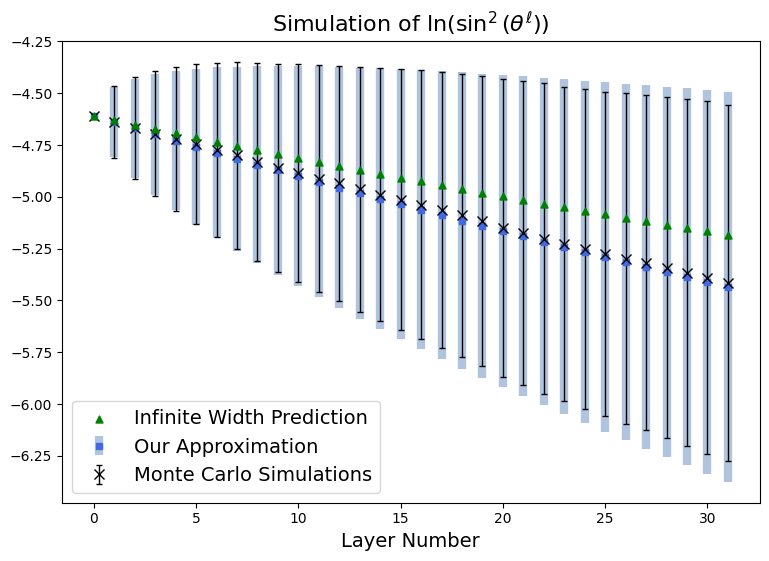

In [13]:
plt.figure(figsize= (9,6), dpi=100)

# Plot our predicted mean and sd
plt.errorbar(np.arange(0,N_depth), ln_sinsq_pred, yerr=sd_pred, markersize=4, fmt='s', color='royalblue', ecolor='lightsteelblue', elinewidth=6, capsize=0, zorder=0, label = "Our Approximation")

# Plot empirical mean and sd from simulations
plt.errorbar(np.arange(0,N_depth), ln_sinsq_mean, yerr=ln_sinsq_sd, fmt='x', color='black', ecolor='black', elinewidth=1, capsize=2, markersize=7, zorder=0, label = "Monte Carlo Simulations")

# Plot infinite width prediction
plt.scatter(np.arange(0,N_depth), ln_sinsq_inf, s=25, marker = "^", color = "green", label = "Infinite Width Prediction")

# Labels
plt.xlabel("Layer Number", fontsize=14)
plt.title("Simulation of $\\ln(\\sin^2(\\theta^\ell))$", fontsize=16)
plt.legend(fontsize = 14)

Here, we plot histograms of the empirical distribution obtained through simulations, and compare that to the predicted probability density functions we calculated earlier.

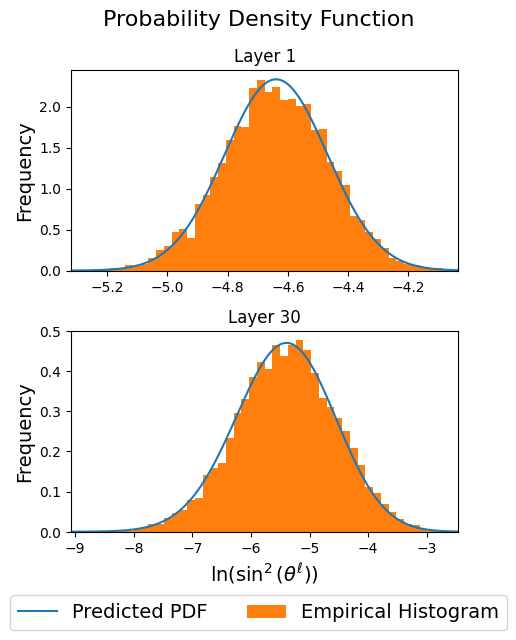

In [14]:
# Specify number of bins in the histogram, and which 2 layers of the network
# we want to look at
N_bins = 50
layer_init = 1
layer_final = 30

# Plot the our predicted probability density function
fig=plt.figure(figsize=(5, 6), dpi=100)
fig.suptitle("Probability Density Function", fontsize=16)
plt.subplots_adjust(hspace=0.3)
plt1 = plt.subplot(2, 1, 1)
plt.plot(x_range, pdf_x[layer_init], label = "_Predicted PDF")
plt.hist(ln_sinsq[layer_init], bins = N_bins, density=True, label = "_Empirical Histogram")
plt.title('Layer {}'.format(layer_init), fontsize=12)
plt.ylabel("Frequency", fontsize=14)
plt.xlim([min(ln_sinsq[layer_init]), max(ln_sinsq[layer_init])])

# Plot the empirical distribution
plt2=plt.subplot(2, 1, 2)
plt.plot(x_range, pdf_x[layer_final], label = "Predicted PDF")
plt.hist(ln_sinsq[layer_final], bins = N_bins, density=True, label = "Empirical Histogram")
plt.title('Layer {}'.format(layer_final), fontsize=12)
plt.xlabel("$\\ln(\\sin^2(\\theta^{\ell}))$", fontsize = 14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim([min(ln_sinsq[layer_final]), max(ln_sinsq[layer_final])])

fig.legend( bbox_to_anchor=(0.5, -0.025),loc = 'center', ncol=2, fontsize=14)

#Perform a Kolmogorov-Smirnov Test
As a last step, we can perform a Kolmogorov-Smirnov test to see if our predicted distribtion is statistically indistinguishable from the simulations. Let $F_n(x)$ be the empirical cumulative distribution function for $n$ iid ordered observations $X_i$. The Kolmogorov-Smirnov statistic for a given cdf $F(x)$ is

$$D_n = \sup_x | F_n(x)- F(x)|$$

ie. it is the greatest distance between the empirical distribution and the cdf.

$H_0$: the empirical data comes from the specified distribution

$H_1$: at least one value does not match the specified distribution

If $D_n$ is greater than the critical value, we reject the null hypothesis.

In [15]:
from statsmodels.distributions.empirical_distribution import ECDF

# specify layer for which you want to perform the K-S test
layer_num = 30

# Calculate predicted cumulative distribution
cdf_x = np.zeros((N_depth, N_points))
cdf_x = np.cumsum(pdf_x, axis = 1)*((x_end-x_start)/N_points)

# Compute the empirical cdf
plt.figure(figsize=(9, 6))
empirical_cdf = ECDF(ln_sinsq[layer_num])

# Now, we will interpolate points on the predicted plot to match those on the
# empirical cdf plot. This way, we can compare the heights of the plots at each
# point
cdf_x_interp = np.interp(empirical_cdf.x, x_range, cdf_x[layer_num])

# Perform K-S test
alpha = 0.05
Dn, pval = stats.kstest(empirical_cdf.y, cdf_x_interp)

print("Layer number:", layer_num)
if pval < alpha:
  print("Reject null hypothesis.\nP value = ", pval, "<", alpha)
else:
  print("Fail to reject null hypothesis - distributions are statistically indistinguishable.\nP value = ", pval, ">", alpha, "\n")

Layer number: 30
Fail to reject null hypothesis - distributions are statistically indistinguishable.
P value =  0.11231565863023929 > 0.05 



<Figure size 900x600 with 0 Axes>

# References
Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Delving deep into recti-
fiers: Surpassing human-level performance on imagenet classification. In 2015 IEEE
International Conference on Computer Vision (ICCV), pages 1026–1034, 2015. doi:
10.1109/ICCV.2015.123

Cameron Jakub and Mihai Nica. Depth degeneracy in neural networks: Vanishing angles in
fully connected ReLU networks on initialization, 2023. URL https://arxiv.org/abs/2302.09712